In [26]:
import json
import os

import dotenv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dotenv.load_dotenv(override=True)

DATA = os.getenv("DATA")
MTSD = os.getenv("MTSD")
if not DATA:
    raise Exception('Not able to find "DATA" environment variable')
if not MTSD:
    raise Exception('Not able to find "MTSD" environment variable')

In [3]:
classes_dir = os.path.join(DATA, 'classes')
anno_dir = os.path.join(MTSD, 'annotations')
print(classes_dir)
print(anno_dir)

C:\Users\saibo\Documents\bachelor_project\data\classes
C:\Users\saibo\Documents\bachelor_project\data\MTSD\annotations


In [4]:
anno_files = os.listdir(anno_dir)
len(anno_files)

41909

In [5]:
with open(os.path.join(classes_dir, "classes.json")) as f:
    classes = json.load(f)
len(classes)

402

In [6]:
with open(os.path.join(classes_dir, 'delete.txt')) as f:
    delete = f.readlines()
delete = [s.replace('\n', '') for s in delete]
delete = [s for s in delete if s != '']
len(delete)

182

In [7]:
new_anno_dir = os.path.join(os.path.dirname(anno_dir), 'anno_2')
os.makedirs(new_anno_dir, exist_ok=True)
print(new_anno_dir)

C:\Users\saibo\Documents\bachelor_project\data\MTSD\anno_2


In [8]:
n_pano = 0
n_in_delete = 0

for anno_file in anno_files:
    with open(os.path.join(anno_dir, anno_file)) as f:
        anno = json.load(f)
    
    if anno['ispano']:
        n_pano += 1
        continue
    
    anno_new = {
        'labels': [],
        'boxes': [],
        'areas': [],
        }
    keep_anno = True

    for obj in anno['objects']:
        if obj['label'] in delete:
            n_in_delete += 1
            keep_anno = False
            break

        anno_new['labels'].append(obj['label'])
        box = obj['bbox']
        anno_new['boxes'].append([box['xmin'], box['ymin'], box['xmax'], box['ymax']])
        anno_new['areas'].append((box['xmax'] - box['xmin']) * (box['ymax'] - box['ymin']))

    if keep_anno:
        filename = os.path.join(new_anno_dir, anno_file)
        with open(filename, "w+") as f:
            json.dump(anno_new, f, indent=6)

n_pano, n_in_delete

(941, 14697)

In [9]:
anno_files = os.listdir(new_anno_dir)
len(anno_files)

26271

In [11]:
n_no_signs = []

for anno_file in anno_files:
    try:
        with open(os.path.join(new_anno_dir, anno_file)) as f:
            anno = json.load(f)
        if len(anno['labels']) == 0:
            n_no_signs += [anno_file]
    except Exception as e:
        print(anno_file)

In [12]:
len(n_no_signs)

128

In [23]:
with open(os.path.join(classes_dir, 'keep.txt')) as f:
    keep = f.readlines()
keep = [s.replace('\n', '') for s in keep]
keep = [s for s in keep if s != '']
len(keep)

56

In [24]:
with open(os.path.join(classes_dir, 'map_mtsd2str.json')) as f:
    map_mtsd2str = json.load(f)
keep_str = list(set([map_mtsd2str[label] for label in keep]))
len(keep_str)

52

In [30]:
count = {}
areas = []

for anno_file in anno_files:
    with open(os.path.join(new_anno_dir, anno_file)) as f:
        anno = json.load(f)

    for label, area in zip(anno['labels'], anno['areas']):
        if label in keep:
            areas.append(area)
            label = map_mtsd2str[label]
            if label in count:
                count[label] += 1
            else:
                count[label] = 1
len(count)

20334

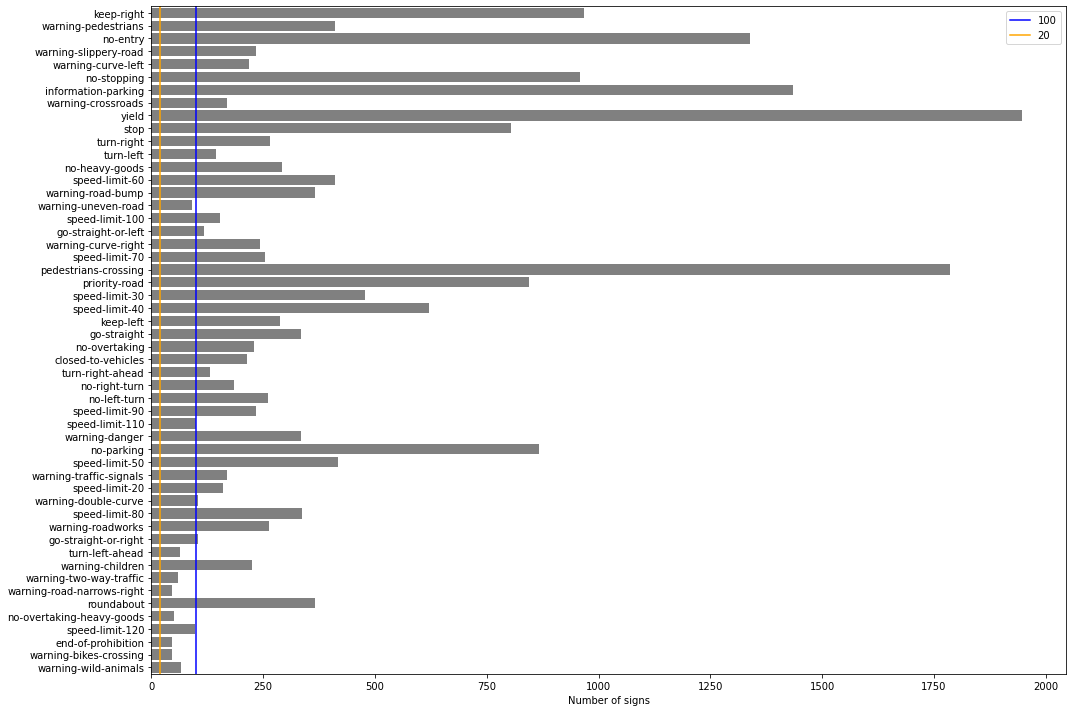

In [86]:
def plot_count(x, y):
    fig = plt.figure(figsize=(15,10))
    sns.barplot(x=x, y=y, color='gray')
    plt.axvline(100, 0, 1, color='blue', label='100')
    plt.axvline(20, 0, 1, color='orange', label='20')
    plt.xlabel('Number of signs')
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_count(x=list(count.values()), y=list(count.keys()))

In [50]:
sorted(count.items(), key=lambda x: x[1])[:5]

[('warning-bikes-crossing', 45),
 ('warning-road-narrows-right', 46),
 ('end-of-prohibition', 46),
 ('no-overtaking-heavy-goods', 51),
 ('warning-two-way-traffic', 59)]

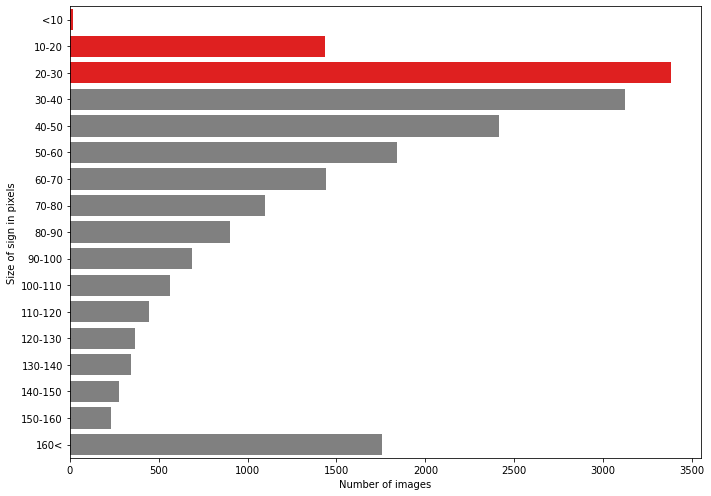

In [92]:
bins = list(range(10, 161, 10))

bin_labels = [str(i-10) + "-" + str(i) for i in bins] + ['160<']
bin_labels[0] = '<10'

bins = {((bin-10)**2, bin**2):0 for bin in bins}
bins[(160**2, 1e8)] = 0

for c in areas:
    for bin in bins:
        if c >= bin[0] and c < bin[1]:
            bins[bin] += 1

x = list(bins.values())
y = [str(key) for key in bins.keys()]
cmap = ['red'] * 3 + ['gray'] * (len(x) - 3)

fig = plt.figure(figsize=(10,7))
sns.barplot(y=y, x=x, palette=cmap)
plt.xlabel('Number of images')
plt.ylabel('Size of sign in pixels')
plt.yticks(np.arange(len(bin_labels)), bin_labels)
plt.tight_layout()
plt.show()

In [85]:
sum(list(bins.values())[:3]), sum(list(bins.values())[3:])

(4837, 15495)

In [94]:
count2 = {}
n_too_small = 0
threshold = 30**2

for anno_file in anno_files:
    with open(os.path.join(new_anno_dir, anno_file)) as f:
        anno = json.load(f)

    for label, area in zip(anno['labels'], anno['areas']):
        if label in keep:
            label = map_mtsd2str[label]
            if area < threshold:
                n_too_small += 1
            else:
                if label in count2:
                    count2[label] += 1
                else:
                    count2[label] = 1
len(count2), n_too_small

(52, 4837)

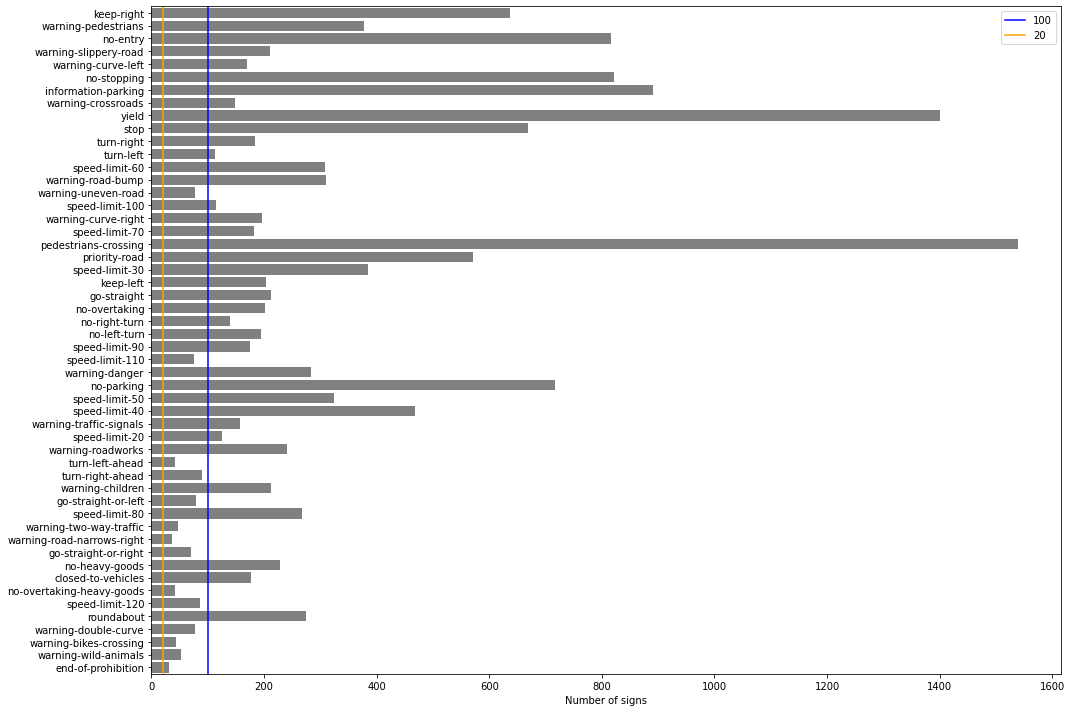

In [95]:
plot_count(x=list(count2.values()), y=list(count2.keys()))

In [96]:
sorted(count2.items(), key=lambda x: x[1])[:5]

[('end-of-prohibition', 31),
 ('warning-road-narrows-right', 36),
 ('turn-left-ahead', 41),
 ('no-overtaking-heavy-goods', 41),
 ('warning-bikes-crossing', 43)]